 # Setup

In [1]:
import pandas as pd
import numpy as np
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks',
    font='Arial', font_scale=1,
    rc={'figure.figsize':(4,4)})
sns.set_palette('pastel')

plt.rcParams["figure.figsize"] = (4,4)
#  (extra)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

%matplotlib inline

ANALYSIS_PATH='/home/sg/wrk/s/matlab/modcell-hpc-study/analysis'

In [2]:
# Utility functions
def write_table(name, dataframe,index=False):
    pd.set_option('display.max_colwidth', -1) # Avoid truncating strings
    with open(name, 'w') as tf:
        tf.write(dataframe.to_latex(index=index).replace('-->',r'$\rightarrow$').replace('<==>',r'$\leftrightarrow$'))

# Table of overall properties

In [3]:
properties = pd.read_csv('./properties.tsv', delimiter='\t')
properties

,Parameters,Carbon source,Compatible products,Minimal cover size
0,a10_b2,arabinose,-1,3
1,a10_b2,galactose,-1,6
2,a10_b2,mannose,-1,5
3,a10_b2,xylose,-1,4
4,a10_b2,glucose,-1,7


In [4]:
# Determine Total compatible products
compatibility_t = .5

def get_compatible(pf_path):
    pf = pd.read_csv(pf_path)
    iscompat = pf[pf.columns[pf.columns.str.contains("objective")]] >= compatibility_t
    anycomp = iscompat.any()
    return [x.replace('(objective)','') for x in 
                        list(anycomp[anycomp==True].index)]

# Sugars
for sugar in ['arabinose', 'galactose', 'mannose', 'xylose']:
    params='a10_b2'
    pf_path = f'{ANALYSIS_PATH}/native-{sugar}/results/{params}.csv'
    properties.loc[properties['Carbon source'] == sugar, 
                   'Compatible products'] = len(get_compatible(pf_path))
# Glucose
pf_path = f'{ANALYSIS_PATH}/native/results/{params}.csv'
properties.loc[properties['Carbon source'] == 'glucose', 
                   'Compatible products'] = len(get_compatible(pf_path))


write_table('overall_properties.tex', properties)    
properties.head()

,Parameters,Carbon source,Compatible products,Minimal cover size
0,a10_b2,arabinose,64,3
1,a10_b2,galactose,79,6
2,a10_b2,mannose,96,5
3,a10_b2,xylose,70,4
4,a10_b2,glucose,93,7


formulask
Galactose  C6H12O6
mannose C6H12O6
arabinose  C5H10O5


# Deletion frequency table

In [5]:
params='a10_b2'
sugars = ['arabinose', 'galactose', 'mannose', 'xylose', 'glucose']

table_paths = {}
dfs = []
for sugar in sugars:
    if sugar == 'glucose':
        table_paths['glucose'] = f'{ANALYSIS_PATH}/native/{params}_topdeletions.csv'
    else:
        table_paths[sugar] = f'{ANALYSIS_PATH}/native-{sugar}/results/{params}_topdeletions.csv'
    df = pd.read_csv(table_paths[sugar], index_col='id')
    #df.drop(['name','formula'], axis=1, inplace=True)
    df.rename({'counts': f'counts_{sugar}'}, axis=1, inplace=True)
    dfs.append(df)


In [6]:
ft = pd.concat(dfs, axis=1,  sort=False)
ft.drop_duplicates(subset=None, keep="first", inplace=True)

ft['counts_average'] = ft[ [f'counts_{sugar}' for sugar in sugars] ].mean(axis=1).round(2)
ft.sort_values(by='counts_average', axis=0, ascending=False, inplace=True)
                      
top = ft.iloc[0:19,:]

# Consolidate formulas and names
def get_item(row):
    for item in row.items():
        if isinstance(item[1], str):
            return item[1]
        
names = top['name'].apply(get_item, axis=1)
formulas =  top['formula'].apply(get_item, axis=1)

top.drop(['formula','name'], axis=1, inplace=True)

top.insert(0, 'formula', formulas)
top.insert(0, 'name', names)

top.fillna(0, inplace=True)

#top = top.round(0)
top.drop(['counts_average'], axis=1, inplace=True)

pd.options.display.float_format = '{:.0f}'.format

# write
write_table('topdeletions.tex',top, index=True)
        
top.head()

/home/sg/.envs/modcell-analysis/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/sg/.envs/modcell-analysis/lib/python3.8/site-packages/pandas/core/frame.py:4252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,name,formula,counts_arabinose,counts_galactose,counts_mannose,counts_xylose,counts_glucose
ALCD2x,Alcohol dehydrogenase (ethanol),etoh_c + nad_c <=> acald_c + h_c + nadh_c,83,83,74,58,91
PPC,Phosphoenolpyruvate carboxylase,co2_c + h2o_c + pep_c --> h_c + oaa_c + pi_c,56,60,65,67,69
TKT2,Transketolase,e4p_c + xu5p__D_c <=> f6p_c + g3p_c,0,54,57,0,46
FLDR2,Flavodoxin reductase (NADPH),2.0 flxso_c + nadph_c --> 2.0 flxr_c + h_c + nadp_c,64,43,43,22,48
ACALD,Acetaldehyde dehydrogenase (acetylating),acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c,60,13,23,64,16


### Heatmap visualization
What are most characteristic deletions for certain carbon sources?
Could also look at subsystems and compare them among carbon sources

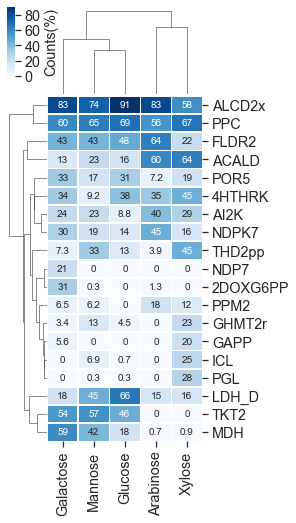

In [7]:
hm_top = top.drop(['name', 'formula'], axis=1)
hm_top.columns = hm_top.columns.str.lstrip('counts_')
hm_top.columns = hm_top.columns.str.title()

g = sns.clustermap(hm_top,
                       cmap="Blues",linewidths=.75, figsize=tuple([3.5,8]),
                  cbar_kws={"label": "Counts(%)"}, annot=True)#,
                       #cbar_kws={"label": "Objective value", "ticks":[0,0.3,0.6,0.9]})
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);
#plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90);

    # Use full name
#g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels())

    # save
g.savefig('deletion-frequencey-hm.svgz', format='svgz')


# Venn diagram of uniquely compatible products

In [8]:
compat_sets = {}
# Sugars
for sugar in ['arabinose', 'galactose', 'mannose', 'xylose']:
    params='a10_b2'
    pf_path = f'{ANALYSIS_PATH}/native-{sugar}/results/{params}.csv'
    compat_sets[sugar] = set(get_compatible(pf_path))
# Glucose
pf_path = f'{ANALYSIS_PATH}/native/results/{params}.csv'
compat_sets['glucose'] = set(get_compatible(pf_path))


In [9]:
from matplotlib_venn import venn3, venn2

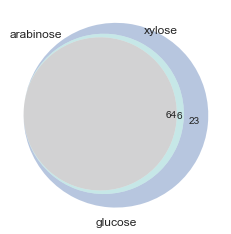

In [10]:
# Glucose and pentoses
subsets = ['arabinose','xylose','glucose']
vd = venn3([compat_sets[subset] for subset in subsets], set_labels=subsets)

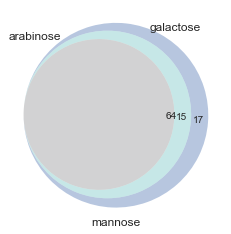

In [11]:
# Hexoses without glucose
subsets = ['arabinose','galactose','mannose']
vd = venn3([compat_sets[subset] for subset in subsets], set_labels=subsets)

/home/sg/.envs/modcell-analysis/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


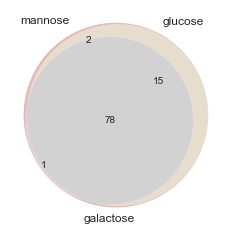

In [12]:
# Top 3
subsets = ['mannose','glucose','galactose']
vd = venn3([compat_sets[subset] for subset in subsets], set_labels=subsets)

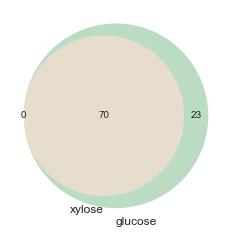

In [13]:
# Glucose vs xylose
subsets = ['xylose','glucose']
vd = venn2([compat_sets[subset] for subset in subsets], set_labels=subsets)

{'pe120', 'ps141', '2odec11eg3p', 'lipidX', '2ippm', '1agpe180', '2agpg160', 'ps120', '4mop', 'pe141', 'apg120', '2agpg180', '1agpg160', '1agpg181', '2tdecg3p', '3mob', '3c2hmp', '2hdecg3p', '2agpg181', 'dha', '1agpg180', '2agpe180', '2odecg3p', '3c3hmp', '23dhmb', '2hdec9eg3p'}


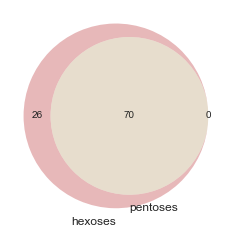

In [24]:
# Hexoses vs pentoses
hexoses = set.union(*[compat_sets[subset] for subset in
                     ['galactose','mannose','glucose']])
pentoses = set.union(*[compat_sets[subset] for subset in 
                       ['xylose','arabinose']])

vd = venn2([hexoses,pentoses], set_labels=['hexoses','pentoses'])
plt.savefig('sugars-compat-venn.svgz')

hexoses_only = hexoses.difference(pentoses)
print(hexoses_only)

In [15]:
# Write out to analyze biochemistry
import pickle

with open('../biochemical-properties/products.pickle', 'wb') as fp:
    pickle.dump([hexoses,pentoses], fp)


### Revisit deletion frequency for hexose-only products

In [83]:
from collections import Counter

params='a10_b2'
#sugars = ['arabinose', 'galactose', 'mannose', 'xylose', 'glucose']
sugars = ['galactose', 'mannose', 'glucose']

table_paths = {}
counts = {}
for sugar in sugars:
    if sugar == 'glucose':
        table_paths['glucose'] = f'{ANALYSIS_PATH}/native/results/{params}.csv'
    else:
        table_paths[sugar] = f'{ANALYSIS_PATH}/native-{sugar}/results/{params}.csv'
    df = pd.read_csv(table_paths[sugar])
    
    # Keep only compatible designs:
    compat_threshold = 0.5
    cdf = df[[f'{pid}(objective)' for pid in hexoses_only]].round(2) >= compat_threshold
    compdf = df[cdf.any(axis=1)]
    
    # Calculate deletion frequency
    n_designs = compdf.shape[0]
    deletions = []
    for x in compdf['Deletion_id'].values.tolist():
        deletions.extend(x.split(', ')) 
    counts[sugar] = {k: (v/n_designs)*100 for k,v in Counter(deletions).items()}
   # dfs.append(df)

In [86]:
fdf = pd.DataFrame.from_dict(counts)
fdf['mean'] = fdf.mean(axis=1)
fdf = fdf.sort_values(by='mean',ascending=False)
fdf = fdf.drop('mean',axis=1)
fdf = fdf.fillna(0)

fdf = fdf.iloc[0:19,:]
write_table('top_hexose_only.tex',fdf, index=True)
fdf.head(20)


,galactose,mannose,glucose
LDH_D,100,98,100
ALCD2x,93,91,100
PPC,73,53,89
FLDR2,73,24,68
TKT2,47,51,60
4HTHRK,47,15,30
THD2pp,33,40,18
LDH_D2,27,0,0
CBMKr,0,19,31
GLUDy,0,18,32


In [74]:
counts['glucose']['MCITS']

0.45045045045045046

In [44]:
from collections import Counter


In [31]:
comp_designs = df[cdf.any(axis=1)]